In [1]:
import numpy as np
import pandas as pd

In [2]:
items = pd.read_csv('../data/archive/items.csv')[['item_id', 'content_type', 'title', 'release_year', 'keywords']]

In [3]:
items.head()

,item_id,content_type,title,release_year,keywords
0,10711,film,Поговори с ней,2002.0,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,2014.0,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,2011.0,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,2015.0,"45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,1978.0,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


## Популярное

In [4]:
interactions = pd.read_csv('../data/archive/interactions.csv', parse_dates=['last_watch_dt'])
interactions.rename({'last_watch_dt': 'datetime'}, axis=1, inplace=True)
interactions.head().merge(items, on='item_id')

,user_id,item_id,datetime,total_dur,watched_pct,content_type,title,release_year,keywords
0,176549,9506,2021-05-11,4250,72.0,film,Холодное сердце,2013.0,"королева, мюзикл, принцесса, предательство, сн..."
1,964868,9506,2021-04-30,6725,100.0,film,Холодное сердце,2013.0,"королева, мюзикл, принцесса, предательство, сн..."
2,699317,1659,2021-05-29,8317,100.0,film,Три богатыря. Ход конем,2014.0,"2014, россия, три, богатыря, ход, конем"
3,656683,7107,2021-05-09,10,0.0,series,Девятаев,2021.0,NaN
4,864613,7638,2021-07-05,14483,100.0,series,Мишель,2018.0,NaN


In [5]:
print('Num users:', len(interactions['user_id'].unique()))
print('Num items:', len(interactions['item_id'].unique()))
print('Num interactions:', len(interactions))
print(
    'Time period:',
    interactions['datetime'].min().strftime('%Y-%m-%d'),
    interactions['datetime'].max().strftime('%Y-%m-%d')
)

Num users: 962179
Num items: 15706
Num interactions: 5476251
Time period: 2021-03-13 2021-08-22


### Модель на коленке

In [6]:
class KolenkaModel:
    def __init__(self, k, days=30):
        self.k = k
        self.days = days
        self.recommendations = []
        
    def fit(self, df):
        min_date = df['datetime'].max() - pd.DateOffset(days=self.days)
        self.recommendations = pd.DataFrame(
            df.loc[df['datetime'] > min_date, 'item_id'].value_counts().head(self.k).index.values,
            columns=['item_id']
        )
    
    def recommend(self, users=None) -> pd.DataFrame:
        if users is None:
            return self.recommendations
        else:
            users = pd.DataFrame(users, columns=['user_id'])
            users['key'] = 1
            self.recommendations['key'] = 1
            return pd.merge(users, self.recommendations, on='key', how='outer').drop('key', axis=1)

In [7]:
model = KolenkaModel(k=10)
model.fit(interactions)

recs = model.recommend(interactions['user_id'].unique())
recs[recs['user_id'] == 176549].merge(items, on='item_id')

,user_id,item_id,content_type,title,release_year,keywords
0,176549,10440,series,Хрустальный,2021.0,"хруст, хрусталь, хруста, хрус, полицейский, пе..."
1,176549,15297,series,Клиника счастья,2021.0,"Клиника счастья, Клиника, Счастье, Клиника сча..."
2,176549,9728,film,Гнев человеческий,2021.0,"ограбление, криминальный авторитет, месть, пер..."
3,176549,13865,film,Девятаев,2021.0,"Девятаев, Девятаева, Девят, Девя, Девята, Девя..."
4,176549,3734,film,Прабабушка легкого поведения,2021.0,", 2021, россия, прабабушка, легкого, поведения"
5,176549,12192,series,Фемида видит,2019.0,"фемида видит, фемида, феми, фем, фемид, фемида..."
6,176549,4151,series,Секреты семейной жизни,2021.0,"брызги крови, кровь, жестокое обращение с живо..."
7,176549,11863,series,Девятаев - сериал,2021.0,NaN
8,176549,7793,film,Радиовспышка,2019.0,"2019, соединенные штаты, радиовспышка"
9,176549,7829,film,Поступь хаоса,2021.0,"по роману или книге, постапокалиптическое буду..."


### Популярное с помощью RecTools

In [8]:
interactions = pd.read_csv('../data/archive/interactions.csv', parse_dates=['last_watch_dt'])
interactions.rename({'last_watch_dt': 'datetime'}, axis=1, inplace=True)

interactions['weight'] = interactions['total_dur'] * interactions['watched_pct'] / 100

interactions['weight'] = interactions['weight'].apply(np.log)
interactions.loc[interactions['weight'] < -100, 'weight'] = -20
interactions.loc[interactions['weight'] > 100, 'weight'] = 20

interactions.head()

,user_id,item_id,datetime,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,8.026170
1,699317,1659,2021-05-29,8317,100.0,9.026057
2,656683,7107,2021-05-09,10,0.0,-20.000000
3,864613,7638,2021-07-05,14483,100.0,9.580731
4,964868,9506,2021-04-30,6725,100.0,8.813587


<Axes: >

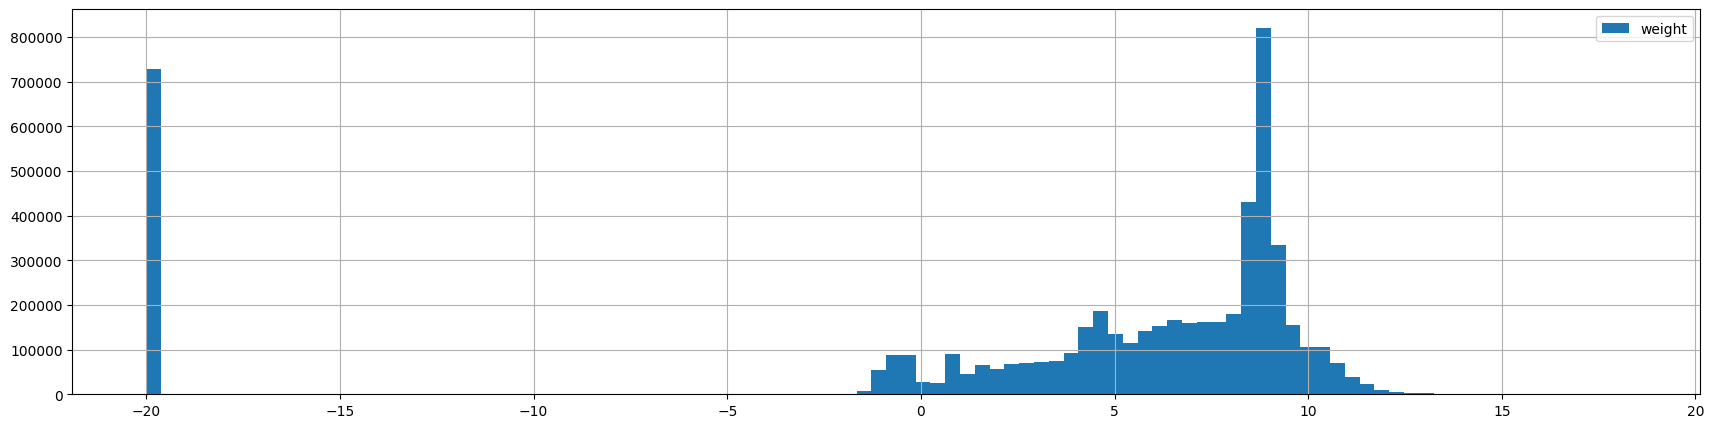

In [9]:
interactions['weight'].hist(bins=100, figsize=(21, 5), legend=True)

In [10]:
from rectools.dataset import Dataset
from rectools.models import PopularModel


dataset = Dataset.construct(interactions)
model = PopularModel('sum_weight')
model.fit(dataset)

pop_recs = model.recommend(
    users=interactions['user_id'].unique(),
    dataset=dataset,
    k=10,
    filter_viewed=True,
)

/Users/juliakup/anaconda3/envs/rectools/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [11]:
pop_recs[pop_recs['user_id'] == 176549].merge(items, on='item_id')

,user_id,item_id,score,rank,content_type,title,release_year,keywords
0,176549,15297,893499.750862,1,series,Клиника счастья,2021.0,"Клиника счастья, Клиника, Счастье, Клиника сча..."
1,176549,13865,675679.923819,2,film,Девятаев,2021.0,"Девятаев, Девятаева, Девят, Девя, Девята, Девя..."
2,176549,10440,628460.794495,3,series,Хрустальный,2021.0,"хруст, хрусталь, хруста, хрус, полицейский, пе..."
3,176549,3734,472980.452576,4,film,Прабабушка легкого поведения,2021.0,", 2021, россия, прабабушка, легкого, поведения"
4,176549,142,237530.869335,5,film,Маша,2020.0,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма..."
5,176549,6809,187503.772397,6,film,Дуров,2021.0,"Компьютер, Монитор, Гений, Интервью, Предприни..."
6,176549,4151,185738.881680,7,series,Секреты семейной жизни,2021.0,"брызги крови, кровь, жестокое обращение с живо..."
7,176549,8636,153893.667980,8,film,Белый снег,2021.0,"биография, занятие спортом, байопик, чемпионат..."
8,176549,11237,142305.264642,9,film,День города,2021.0,"2021, россия, день, города"
9,176549,7571,124361.525741,10,film,100% волк,2020.0,"пудель, подростковая тревога, оборотень, приня..."


## Item2Item

In [12]:
items_df = pd.read_csv('../data/archive/items.csv').drop(columns=['title_orig', 'studios'])
items_df['actors'] = items_df['actors'].fillna('')
items_df['description'] = items_df['description'].fillna('')
items_df['keywords'] = items_df['keywords'].fillna('')
items_df.shape

(15963, 12)

In [13]:
items_df['keywords'][1]

'Голые, перцы, 2014, США, друзья, свадьбы, преодоление, трудностей, расставания, отношения, дружба, риск, недоразумение, мужская, дружба, мальчишники, девичники'

In [14]:
items_df.head(3)

,item_id,content_type,title,release_year,genres,countries,for_kids,age_rating,directors,actors,description,keywords
0,10711,film,Поговори с ней,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


class Item2ItemRecommender:
    
    def __init__(self, k: int = 10):
        self.k = k
        
    def fit(self, items_df, corpus):
        tf = TfidfVectorizer()
        tfidf_matrix = tf.fit_transform(corpus)
        self.cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
        self.indices = pd.Series(items_df.index, index=items_df['item_id'])
        self.items_df = items_df
    
    def recommend(self, user_history):
        indices = pd.Series(self.items_df.index, index=self.items_df['item_id'])  # item_id -> index
        idx = indices.loc[user_history['item_id']]  # item_id -> index
        sim_scores = [
            (idx.iloc[id_], nxt, score)  # curr item index, next item index, score
            for id_, sim in enumerate(np.take(self.cosine_sim, idx, axis=0))
            for nxt, score in enumerate(sim)
        ]
        sim_scores_df = pd.DataFrame(sim_scores, columns=['idx', 'next', 'score'])
        sim_scores_df['sort'] = sim_scores_df.sort_values('score', ascending=False).groupby('idx').cumcount() + 1
        sim_scores_df = sim_scores_df[sim_scores_df['sort'].between(2, self.k + 1)]
        titles = self.items_df[['title', 'content_type', 'release_year', 'keywords']] \
                   .reset_index().rename(columns={'index': 'next'})
        idx_df = pd.DataFrame(idx, columns=['idx']).reset_index() # index, idx
        sim_scores_df = sim_scores_df.merge(idx_df).merge(titles)\
                          .sort_values(['item_id', 'score'], ascending=[True, False])
        
        return sim_scores_df.drop(columns=['idx', 'sort', 'next'])

In [16]:
interactions[interactions['user_id'] == 265110].merge(items).sort_values('item_id', ascending=False).tail(3)

,user_id,item_id,datetime,total_dur,watched_pct,weight,content_type,title,release_year,keywords
10,265110,1106,2021-03-31,4305,60.0,7.856707,film,Железный человек 2,2010.0,"технологии, малибу, супергерой, месть, 2000-е,..."
1,265110,330,2021-03-28,6892,100.0,8.838117,film,Книга джунглей,2016.0,"основано на романе или книге, змея, волк, слон..."
2,265110,144,2021-04-01,721,10.0,4.278054,film,Железный человек 3,2013.0,"война с террором, Теннесси, Малибу, Супергерой..."


In [17]:
model = Item2ItemRecommender(k=3)
model.fit(items_df, items_df['keywords'])
model.recommend(interactions[interactions['user_id'] == 265110]).head(9)

,score,item_id,title,content_type,release_year,keywords
9,0.411068,144,G.I. Joe: Бросок кобры 2,film,2013.0,"убийца, тайна, технология, ракеты, боеголовки,..."
8,0.404432,144,Штурм Белого дома,film,2013.0,"белый дом, президент соединенных штатов, загов..."
10,0.367648,144,Мачете убивает,film,2013.0,"Мексика, Белый дом, ядерная ракета, мачете, пр..."
5,0.444355,330,Книга джунглей (1967),film,1967.0,"основано на романе или книге, индийский поводо..."
7,0.331348,330,Книга джунглей 2,film,2003.0,"река, мюзикл, тигр, деревня, дикий ребенок, пр..."
6,0.242535,330,Удивительное путешествие доктора Дулиттла,film,2020.0,"по мотивам романа или книги, корабль, викториа..."
37,0.369074,1106,Железный человек,film,2008.0,"Ближний Восток, торговец оружием, Малибу, супе..."
35,0.314045,1106,Тор,film,2011.0,"Нью-Мексико, изгнание, супергерой, основанный ..."
2,0.311599,1106,Мстители: Эра Альтрона,film,2015.0,"продолжение, супергерой, основанный на комикса..."


## Metrics

In [18]:
from rectools.metrics import MAP, NDCG, Precision

In [19]:
interactions = pd.read_csv('../data/archive/interactions.csv', parse_dates=['last_watch_dt'])
interactions.rename({'last_watch_dt': 'datetime'}, axis=1, inplace=True)
interactions['weight'] = interactions['watched_pct']
interactions['datetime'].min(), interactions['datetime'].max()

(Timestamp('2021-03-13 00:00:00'), Timestamp('2021-08-22 00:00:00'))

<Axes: >

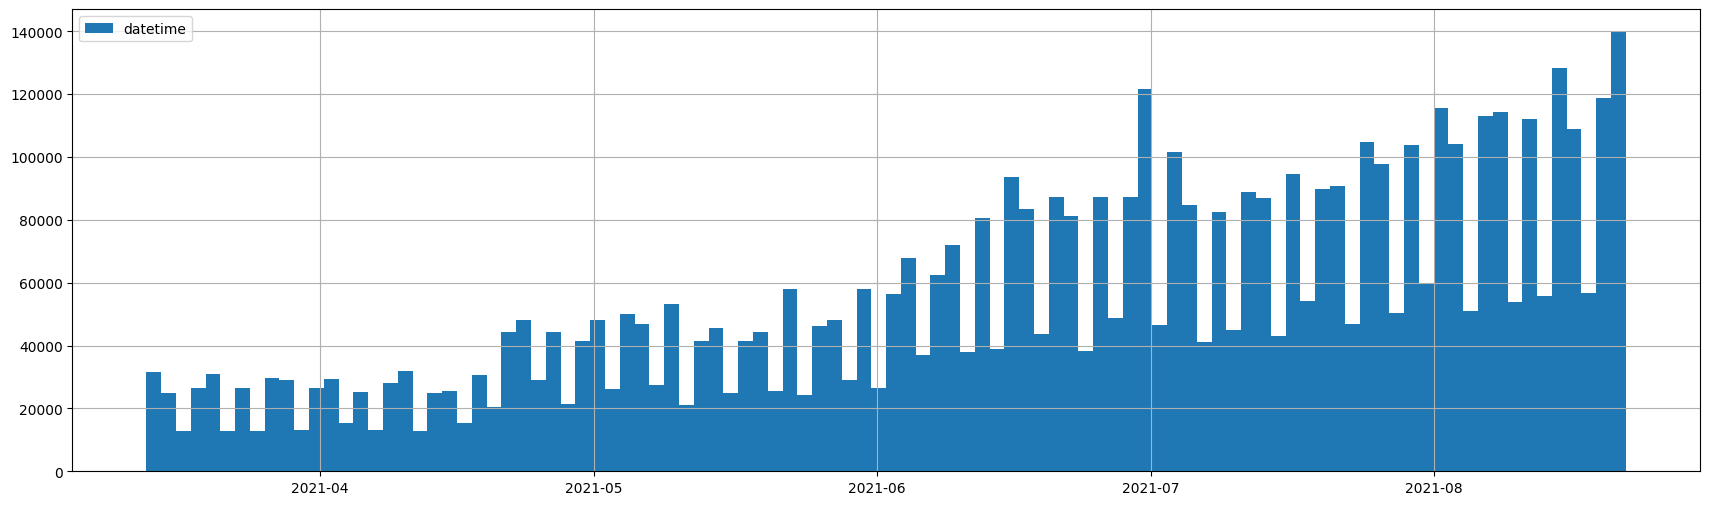

In [20]:
interactions['datetime'].hist(bins=100, figsize=(21, 6), legend=True)

In [21]:
split_dt = pd.Timestamp("2021-08-14")
df_train = interactions.loc[interactions["datetime"] < split_dt]
df_test = interactions.loc[interactions["datetime"] >= split_dt]

In [22]:
dataset = Dataset.construct(df_train)
model = PopularModel('sum_weight')
model.fit(dataset)

pop_recs = model.recommend(
    users=df_train['user_id'].unique(),
    dataset=dataset,
    k=10,
    filter_viewed=True,
)

In [23]:
precision = Precision(k=10).calc(reco=pop_recs, interactions=df_test)
ndcg = NDCG(k=10).calc(reco=pop_recs, interactions=df_test)
map_ = MAP(k=10).calc(reco=pop_recs, interactions=df_test)
print('Precision:', precision, 'NDCG:', ndcg, 'MAP', map_)

Precision: 0.02034415257002185 NDCG: 0.026871487867533992 MAP 0.04918437364900765


## Collaborative filtering

In [24]:
import os

from implicit.als import AlternatingLeastSquares
from rectools.models import ImplicitALSWrapperModel


os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

In [25]:
interactions = pd.read_csv('../data/archive/interactions.csv', parse_dates=['last_watch_dt'])
interactions.rename({'last_watch_dt': 'datetime'}, axis=1, inplace=True)
interactions['weight'] = interactions['watched_pct']

split_dt = pd.Timestamp("2021-08-14")
df_train = interactions.loc[interactions["datetime"] < split_dt]
df_test = interactions.loc[interactions["datetime"] >= split_dt]

In [26]:
dataset = Dataset.construct(df_train)

In [27]:
%%time
model = ImplicitALSWrapperModel(AlternatingLeastSquares(factors=8, random_state=42, num_threads=1))
model.fit(dataset)

recs = model.recommend(
    users=df_train['user_id'].unique(),
    dataset=dataset,
    k=10,
    filter_viewed=True,
)

CPU times: user 46min 54s, sys: 44.4 s, total: 47min 39s
Wall time: 6min 41s


In [28]:
recs.head()

,user_id,item_id,score,rank
0,176549,16361,1.562495,1
1,176549,1819,1.446069,2
2,176549,11310,1.277756,3
3,176549,4774,1.248165,4
4,176549,12869,1.233787,5


In [29]:
precision = Precision(k=10).calc(reco=recs, interactions=df_test)
ndcg = NDCG(k=10).calc(reco=recs, interactions=df_test)
map_ = MAP(k=10).calc(reco=recs, interactions=df_test)
print('Precision:', precision, 'NDCG:', ndcg, 'MAP', map_)

Precision: 0.01743650330706793 NDCG: 0.02084578306435786 MAP 0.033981696916868566


### Hybrid

In [30]:
items_df = pd.read_csv('../data/archive/items.csv').drop(columns=['title_orig', 'studios'])
users_df = pd.read_csv('../data/archive/users.csv')

users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [31]:
users_df.nunique()

user_id     840197
age              6
income           6
sex              2
kids_flg         2
dtype: int64

In [32]:
users_df = users_df[users_df['user_id'].isin(df_train['user_id'])]
items_df = items_df[items_df['item_id'].isin(df_train['item_id'])]

In [33]:
user_features_frames = []
for feature in ["sex", "income", "age"]:
    feature_frame = users_df.reindex(columns=["user_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


In [34]:
items_df["genre"] = items_df["genres"].str.split(",")
genre_feature = items_df[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [35]:
items_df['release_year'].isna().sum()

95

In [36]:
items_df = items_df.fillna({'release_year': 2010})
_, bins = pd.qcut(items_df["release_year"], 10, retbins=True)
labels = bins[:-1]
print(labels)

year_feature = pd.DataFrame(
    {
        "id": items_df["item_id"],
        "value": pd.cut(items_df["release_year"], bins=bins, labels=labels),
        "feature": "release_year",
    }
)

item_features = pd.concat((genre_feature, year_feature))

[1897. 1983. 2003. 2009. 2012. 2014. 2016. 2017. 2019. 2020.]


In [37]:
dataset = Dataset.construct(
    interactions_df=df_train,
    user_features_df=user_features,
    cat_user_features=["sex", "income", "age"],
    item_features_df=item_features,
    cat_item_features=["release_year", "genre"],  # If we didn't binarize year, we wouldn't set it here
)

In [ ]:
from rectools.metrics import (
    MAP,
    MeanInvUserFreq,
    calc_metrics,
)

metrics = {"MAP": MAP(10), "Novelty": MeanInvUserFreq(10)}

for fit_features_together in (True, False):
    model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(factors=32, random_state=42, num_threads=1),
        fit_features_together=fit_features_together
    )
    model.fit(dataset)
    recos = model.recommend(
        users=df_train['user_id'].unique(),
        dataset=dataset,
        k=10,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, df_test, df_train)
    print(f"Fit features together: {fit_features_together}.  Metrics: {metric_values}")

/Users/juliakup/anaconda3/envs/rectools/lib/python3.8/site-packages/rectools/dataset/features.py:399: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")
